In [144]:
# Standard DS modules
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 200)

# Visualization modules
import altair.vegalite.v2 as alt
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

# Model-related modules
import category_encoders as ce
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Utilities
import stackprinter

stackprinter.set_excepthook(style="darkbg")

In [2]:
features_df = pd.read_csv("~/data/train_features.csv")
labels_df = pd.read_csv("~/data/train_labels.csv")
print(features_df.shape, labels_df.shape)
features_df.head()

(59400, 40) (59400, 2)


id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  
0  groundwater           communal standpipe    communal standpipe  
1      surface           communal standpipe    communal standpipe  
2      surface  communal standpipe multiple    communal standpipe  
3  groundwater  communal standpipe multiple    communal standpipe 

# Baseline Model

The baseline model I've chosen is a decision tree classifier. This model offers more interpretable results, as well as being more robust to unscaled input data; A good option for a fast first baseline. A good alternative configuration might be a "decision stump."

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    features_df.drop(columns="id"),
    labels_df["status_group"],
    stratify=labels_df["status_group"],
    test_size=0.3,
    random_state=42,
)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(41580, 39) (17820, 39) (41580,) (17820,)


In [4]:
X_train.select_dtypes("number").head()

amount_tsh  gps_height  longitude  latitude  num_private  region_code  \
5974          0.0        1410  36.667568 -3.353465            0            2   
31787         0.0        1161  33.637501 -2.139160            0           20   
27800         0.0        1184  36.854557 -2.977996            0            2   
8008          0.0           0  33.023974 -2.933736            0           19   
39725         0.0        1331  36.528004 -5.674631            0           21   

       district_code  population  construction_year  
5974               2         200               2010  
31787              4         400               1996  
27800              6         550               2009  
8008               7           0                  0  
39725              5           1               2006

In [5]:
# Score baseline with all numeric features
clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train.select_dtypes("number"), y_train)
clf.score(X_val.select_dtypes("number"), y_val)

0.665712682379349

In [6]:
# What are the important numeric features?
pd.Series(
    clf.feature_importances_, X_train.select_dtypes("number").columns
).sort_values(ascending=False)

longitude            0.325768
latitude             0.298232
gps_height           0.117843
population           0.090265
construction_year    0.076714
amount_tsh           0.057249
district_code        0.020671
region_code          0.011549
num_private          0.001710
dtype: float64

In [7]:
# Baseline model confusion matrix
y_pred = clf.predict(X_val.select_dtypes("number"))
columns = [f"Predicted {label}" for label in np.unique(y_val)]
index = [f"Actual {label}" for label in np.unique(y_val)]
pd.DataFrame(confusion_matrix(y_val, y_pred), columns=columns, index=index)

Predicted functional  \
Actual functional                               7057   
Actual functional needs repair                   628   
Actual non functional                           2120   

                                Predicted functional needs repair  \
Actual functional                                             568   
Actual functional needs repair                                369   
Actual non functional                                         290   

                                Predicted non functional  
Actual functional                                   2053  
Actual functional needs repair                       298  
Actual non functional                               4437

In [8]:
X_train.describe(exclude="number").T.sort_values(by="unique")

count unique                      top   freq
recorded_by            41580      1  GeoData Consultants Ltd  41580
public_meeting         39283      2                     True  35748
permit                 39429      2                     True  27190
source_class           41580      3              groundwater  32085
management_group       41580      5               user-group  36821
quantity_group         41580      5                   enough  23232
quantity               41580      5                   enough  23232
waterpoint_type_group  41580      6       communal standpipe  24183
quality_group          41580      6                     good  35496
payment_type           41580      7                never pay  17792
source_type            41580      7                   spring  11944
waterpoint_type        41580      7       communal standpipe  19911
extraction_type_class  41580      7                  gravity  18766
payment                41580      7                never pay  17792
water_quality          41580      8                     soft  35496
basin                  41580      9            Lake Victoria   7058
source                 41580     10                   spring  11944
scheme_management      38848     12                      VWC  25837
management             41580     12                      vwc  28454
extraction_type_group  41580     13                  gravity  18766
extraction_type        41580     18                  gravity  18766
region                 41580     21                   Iringa   3752
lga                    41580    124                   Njombe   1769
date_recorded          41580    346               2011-03-17    410
funder                 39034   1611   Government Of Tanzania   6405
installer              39025   1802                      DWE  12204
ward                   41580   2073                    Igosi    222
scheme_name            21843   2472                        K    488
subvillage             41336  16078                  Majengo    364
wpt_name               41580  27265                     none   2546

In [9]:
# Score baseline with important numeric features and encoded categorical features
# OneHot Encode up to 10 unique categories
features = [
    "public_meeting",
    "permit",
    "source",
    "management_group",
    "quantity",
    "waterpoint_type",
    "payment",
    "basin",
]
encoder = ce.OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train[features])
X_val_encoded = encoder.transform(X_val[features])

In [10]:
# Make an X_train with encoded features and top numeric features
X_train_encoded[["latitude", "longitude", "gps_height", "population"]] = X_train[
    ["latitude", "longitude", "gps_height", "population"]
]
X_val_encoded[["latitude", "longitude", "gps_height", "population"]] = X_val[
    ["latitude", "longitude", "gps_height", "population"]
]

In [10]:
X_train_encoded.head()

recorded_by_1  public_meeting_1  public_meeting_2  public_meeting_3  \
5974               1                 1                 0                 0   
31787              1                 0                 1                 0   
27800              1                 1                 0                 0   
8008               1                 0                 0                 1   
39725              1                 1                 0                 0   

       permit_1  permit_2  permit_3  source_1  source_2  source_3  source_4  \
5974          1         0         0         1         0         0         0   
31787         1         0         0         0         1         0         0   
27800         1         0         0         0         0         1         0   
8008          1         0         0         0         1         0         0   
39725         1         0         0         0         0         0         1   

       source_5  source_6  source_7  source_8  source_9  source_10  \
5974          0         0         0         0         0          0   
31787         0         0         0         0         0          0   
27800         0         0         0         0         0          0   
8008          0         0         0         0         0          0   
39725         0         0         0         0         0          0   

       management_group_1  management_group_2  management_group_3  \
5974                    1                   0                   0   
31787                   0                   1                   0   
27800                   0                   0                   1   
8008                    0                   0                   0   
39725                   1                   0                   0   

       management_group_4  management_group_5  quantity_1  quantity_2  \
5974                    0                   0           1           0   
31787                   0                   0           1           0   
27800                   0                   0           0           1   
8008                    1                   0           1           0   
39725                   0                   0           0           1   

       quantity_3  quantity_4  quantity_5  waterpoint_type_1  \
5974            0           0           0                  1   
31787           0           0           0                  0   
27800           0           0           0                  1   
8008            0           0           0                  0   
39725           0           0           0                  0   

       waterpoint_type_2  waterpoint_type_3  waterpoint_type_4  \
5974                   0                  0                  0   
31787                  1                  0                  0   
27800                  0                  0                  0   
8008                   1                  0                  0   
39725                  1                  0                  0   

       waterpoint_type_5  waterpoint_type_6  waterpoint_type_7  payment_1  \
5974                   0                  0                  0          1   
31787                  0                  0                  0          1   
27800                  0                  0                  0          0   
8008                   0                  0                  0          0   
39725                  0                  0                  0          0   

       payment_2  payment_3  payment_4  payment_5  payment_6  payment_7  \
5974           0          0          0          0          0          0   
31787          0          0          0          0          0          0   
27800          1          0          0          0          0          0   
8008           0          1          0          0          0          0   
39725          0          1          0          0          0          0   

       basin_1  basin_2  basin_3  basin_4  basin_5  basin_6  basin_7  basin_8  \
5974       

In [11]:
# Score baseline with selected encoded features and top numeric features
clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train_encoded, y_train)
clf.score(X_val_encoded, y_val)

0.7436026936026936

In [12]:
# Generate classification report for this model
y_pred = clf.predict(X_val_encoded)
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.79      0.79      9678
functional needs repair       0.36      0.37      0.37      1295
         non functional       0.76      0.75      0.75      6847

               accuracy                           0.74     17820
              macro avg       0.63      0.64      0.64     17820
           weighted avg       0.74      0.74      0.74     17820



# Re-Score with XGBoost Classifier

For the search space I wanted to keep the total space as low as possible to accomodate so few iterations (5). I also used only three cross-validation folds which was a tradeoff in favor of speed- for my own rapid prototyping.

I'm continuing to use the slightly-engineered `X_train_encoded` data from the DecisionTreeClassifier models. I didn't tamper with the data so I could get a better comparison between a single-tree model and a gradient-boosted ensemble model. 

In [13]:
# (Random) Search hyperparameter space
search_space = {
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "n_estimators": [100, 150, 200],
    "gamma": [0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.8, 1.0],
    "min_child_weight": [0, 1, 2, 3],
}

opt = RandomizedSearchCV(
    XGBClassifier(
        booster="gbtree",
        objective="multi:softmax",
        num_class=3,
        random_state=42,
        n_jobs=-1,
        verbose=3,
    ),
    param_distributions=search_space,
    n_iter=5,
    cv=3,
    verbose=3,
    random_state=42,
    n_jobs=-1,
)

In [14]:
# Search
opt.fit(X_train_encoded, y_train)
# Assign highest scoring XGB configuration
best = opt.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.1min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.6min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.0min finished


------

Same procedure as with the decision tree: generate predictions with the best (pre-fit) model, calculate accuracy and classification report. Was there an improvement with this new model? 

In [15]:
# Generate classification report for this model
y_pred = best.predict(X_val_encoded)
print("Accuracy score: ", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy score:  0.7873737373737374
                         precision    recall  f1-score   support

             functional       0.79      0.88      0.83      9678
functional needs repair       0.52      0.30      0.38      1295
         non functional       0.82      0.75      0.78      6847

               accuracy                           0.79     17820
              macro avg       0.71      0.64      0.66     17820
           weighted avg       0.78      0.79      0.78     17820



In [16]:
# View feature importances of best
pd.Series(best.feature_importances_, X_train_encoded.columns).sort_values(
    ascending=False
)

latitude              0.271851
longitude             0.267277
gps_height            0.132231
population            0.089374
quantity_1            0.014567
permit_1              0.011049
payment_3             0.010978
quantity_2            0.010697
source_4              0.009923
waterpoint_type_4     0.009606
source_1              0.009360
waterpoint_type_1     0.009113
waterpoint_type_3     0.008621
waterpoint_type_2     0.008128
payment_4             0.008093
payment_5             0.008023
source_6              0.007952
public_meeting_1      0.007600
management_group_1    0.007072
source_3              0.006615
quantity_4            0.006615
payment_1             0.006298
source_7              0.006263
payment_2             0.005172
management_group_2    0.004856
quantity_3            0.004187
public_meeting_3      0.004011
public_meeting_2      0.004011
payment_6             0.003976
permit_2              0.003765
basin_3               0.003413
basin_5               0.003343
quantity

# Try to Improve Score with Feature Engineering

In [17]:
def wrangle(X, bin_latlong=True, round_to_n=2):
    df = X.copy()

    # Impute missing observations
    df.fillna(method="pad", inplace=True)

    if bin_latlong:
        df["latitude"] = round(df["longitude"], round_to_n)
        df["longitude"] = round(df["longitude"], round_to_n)

    cols_to_drop = [
        "id",
        "recorded_by",
        "wpt_name",
        "extraction_type_group",
        "extraction_type_class",
        "management",
        "waterpoint_type_group",
        "quantity_group",
        "payment_type",
        "subvillage",
        "scheme_name",
        "num_private",
        "source_class",
        "source",
        "quality_group",
        "region_code",
    ]

    label_categoricals = [
        "scheme_management",
        "management_group",
        "region",
        "ward",
        "extraction_type",
        "waterpoint_type",
        "water_quality",
        "installer",
        "funder",
        "lga",
        "basin",
        "public_meeting",
        "permit",
        "payment",
        "source_type",
        "quantity",
    ]

    # Drop unhelpful features
    df = df.drop(columns=cols_to_drop)

    # Engineer numeric date feature: Unix time conversion
    df["date_recorded"] = (
        pd.DatetimeIndex(pd.to_datetime(df["date_recorded"])).astype(np.int64) / 10 ** 9
    )

    # Initialize encoder and transform categorical features
    label_enc = LabelEncoder()
    for feature in label_categoricals:
        df[feature] = label_enc.fit_transform(df[feature])

    print("Final shape: ", df.shape)
    return df

In [18]:
wrangled_features = wrangle(features_df, round_to_n=1)
wrangled_features.head()

Final shape:  (59400, 24)


amount_tsh  date_recorded  funder  gps_height  installer  longitude  \
0      6000.0   1.300061e+09    1369        1390       1518       34.9   
1         0.0   1.362528e+09     469        1399        545       34.7   
2        25.0   1.361750e+09     825         686       2048       37.5   
3         0.0   1.359331e+09    1741         263       1852       38.5   
4         0.0   1.310515e+09      20           0        119       31.1   

   latitude  basin  region  district_code  lga  ward  population  \
0      34.9      1       3              5   51  1426         109   
1      34.7      4       9              2  103  1576         280   
2      37.5      5       8              4  108  1624         250   
3      38.5      7      12             63   87  1571          58   
4      31.1      4       4              1   26  1687           0   

   public_meeting  scheme_management  permit  construction_year  \
0               1                  7       0               1999   
1               1                  2       1               2010   
2               1                  7       1               2009   
3               1                  7       1               1986   
4               1                  7       1                  0   

   extraction_type  management_group  payment  water_quality  quantity  \
0                3                 4        2              6         1   
1                3                 4        0              6         2   
2                3                 4        4              6         1   
3               14                 4        0              6         0   
4                3                 1        0              6         3   

   source_type  waterpoint_type  
0            6                1  
1            3                1  
2            1                2  
3            0                2  
4            3                1

In [21]:
# New Train/Test split
X_train, X_val, y_train, y_val = train_test_split(
    wrangled_features,
    labels_df["status_group"],
    stratify=labels_df["status_group"],
    test_size=0.3,
    random_state=42,
)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(41580, 24) (17820, 24) (41580,) (17820,)


### Fit Model and Evaluate Acccuracy

In [22]:
# Search with new features
opt.fit(X_train, y_train)

# Assign highest scoring XGB configuration
best = opt.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   51.8s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.2min remaining:   35.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.4min finished


In [23]:
# Generate classification report for this model
y_pred = best.predict(X_val)
print("Accuracy score: ", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy score:  0.8029180695847362
                         precision    recall  f1-score   support

             functional       0.80      0.89      0.84      9678
functional needs repair       0.56      0.32      0.40      1295
         non functional       0.84      0.77      0.80      6847

               accuracy                           0.80     17820
              macro avg       0.73      0.66      0.68     17820
           weighted avg       0.80      0.80      0.80     17820



In [24]:
# View feature importances of best
pd.Series(best.feature_importances_, X_train.columns).sort_values(ascending=False)

gps_height           0.123005
ward                 0.110318
date_recorded        0.102336
population           0.081919
funder               0.079903
installer            0.063267
longitude            0.063267
construction_year    0.057637
lga                  0.048983
extraction_type      0.035120
quantity             0.026886
district_code        0.024870
source_type          0.024786
waterpoint_type      0.024702
payment              0.023189
amount_tsh           0.021929
region               0.018988
scheme_management    0.018568
basin                0.015628
water_quality        0.013527
management_group     0.008654
permit               0.007982
public_meeting       0.004537
latitude             0.000000
dtype: float32

### Submit Predictions to Kaggle

In [25]:
test_features = wrangle(pd.read_csv("~/data/test_features.csv"))
y_pred = best.predict(test_features)

sample_submission = pd.read_csv("~/data/sample_submission.csv")
submission = sample_submission.copy()
submission["status_group"] = y_pred
submission.to_csv("joseph_wagner_submission.csv", index=False)

Final shape:  (14358, 24)


# EDA Visualizations

In [34]:
merged = features_df.merge(labels_df, on='id')
merged = wrangle(merged, bin_latlong=False)

Final shape:  (59400, 25)


In [35]:
merged.head()

amount_tsh  date_recorded  funder  gps_height  installer  longitude  \
0      6000.0   1.300061e+09    1369        1390       1518  34.938093   
1         0.0   1.362528e+09     469        1399        545  34.698766   
2        25.0   1.361750e+09     825         686       2048  37.460664   
3         0.0   1.359331e+09    1741         263       1852  38.486161   
4         0.0   1.310515e+09      20           0        119  31.130847   

    latitude  basin  region  district_code  lga  ward  population  \
0  -9.856322      1       3              5   51  1426         109   
1  -2.147466      4       9              2  103  1576         280   
2  -3.821329      5       8              4  108  1624         250   
3 -11.155298      7      12             63   87  1571          58   
4  -1.825359      4       4              1   26  1687           0   

   public_meeting  scheme_management  permit  construction_year  \
0               1                  7       0               1999   
1               1                  2       1               2010   
2               1                  7       1               2009   
3               1                  7       1               1986   
4               1                  7       1                  0   

   extraction_type  management_group  payment  water_quality  quantity  \
0                3                 4        2              6         1   
1                3                 4        0              6         2   
2                3                 4        4              6         1   
3               14                 4        0              6         0   
4                3                 1        0              6         3   

   source_type  waterpoint_type    status_group  
0            6                1      functional  
1            3                1      functional  
2            1                2      functional  
3            0                2  non functional  
4            3                1      functional

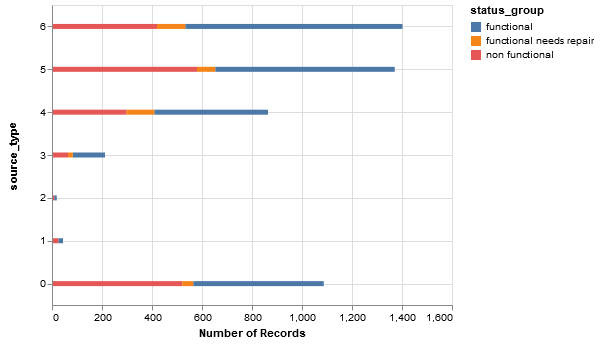

In [36]:
alt.Chart(merged[:4999]).mark_bar().encode(
    x='count(source_type)',
    y='source_type',
    color='status_group',
)

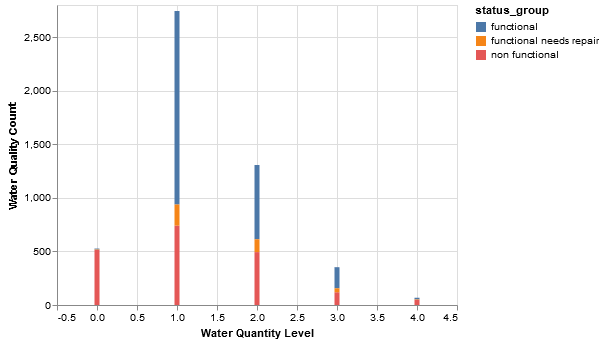

In [37]:
alt.Chart(merged[:4999]).mark_bar().encode(
    alt.X('quantity', title='Water Quantity Level'),
    alt.Y('count(quantity)', title='Water Quality Count'),
    color='status_group',
)

In [38]:
merged.groupby('quantity')['status_group'].count()

quantity
0     6246
1    33186
2    15129
3     4050
4      789
Name: status_group, dtype: int64

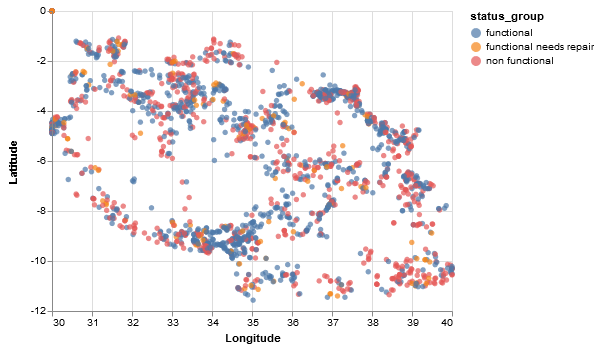

In [112]:
alt.Chart(merged.loc[merged['latitude']!=0][:2000]).mark_circle().encode(
    alt.X('longitude:Q', title='Longitude', scale=alt.Scale(domain=(30,40), clamp=True)),
    alt.Y('latitude:Q', title='Latitude'),
    color='status_group:N',
    # size='population:Q',
    tooltip=['population', 'status_group', 'quantity']
)

In [120]:
le = LabelEncoder()
merged['encoded_status'] = le.fit_transform(merged['status_group'])
labels = merged['status_group']
print(le.classes_)
merged[['status_group', 'encoded_status']].head()
merged.drop(columns='status_group', inplace=True)

['functional' 'functional needs repair' 'non functional']


In [129]:
best.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 1.0,
 'learning_rate': 0.6,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 2,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1,
 'num_class': 3,
 'verbose': 3}

In [131]:
pdp_model = XGBClassifier(
     base_score= 0.5,
     booster= 'gbtree',
     colsample_bylevel= 1,
     colsample_bytree= 1,
     gamma= 1.0,
     learning_rate= 0.6,
     max_delta_step= 0,
     max_depth= 7,
     min_child_weight= 2,
     missing= None,
     n_estimators= 100,
     n_jobs= 1,
     nthread= None,
     objective= 'multi:softprob',
     random_state= 42,
     reg_alpha= 0,
     reg_lambda= 1,
     scale_pos_weight= 1,
     seed= None,
     silent= True,
     subsample= 1,
     num_class= 3,
     verbose= 3
)

pdp_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=1.0, learning_rate=0.6,
              max_delta_step=0, max_depth=7, min_child_weight=2, missing=None,
              n_estimators=100, n_jobs=1, nthread=None, num_class=3,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1, verbose=3)

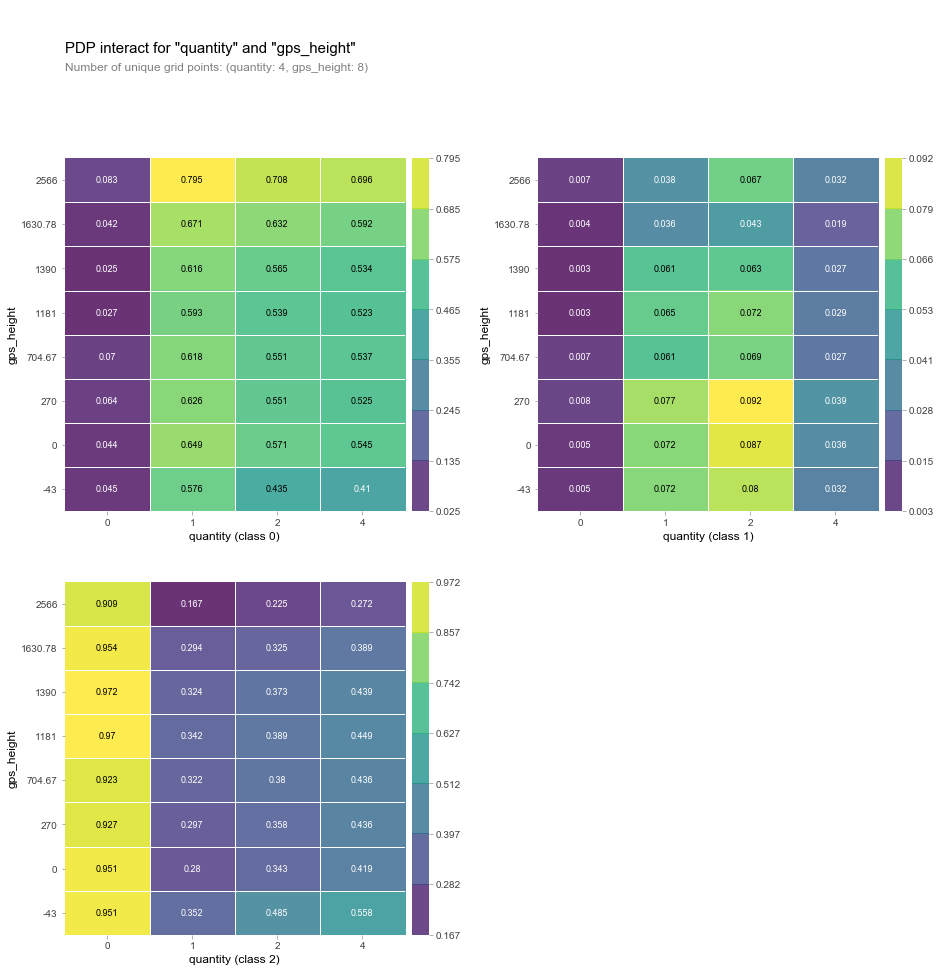

In [136]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot 

features = ['quantity', 'gps_height']
interaction = pdp_interact(
                model=pdp_model,
                dataset=X_val.loc[X_val['latitude']!=0][:2000],
                model_features=X_val.columns,
                features=features,
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

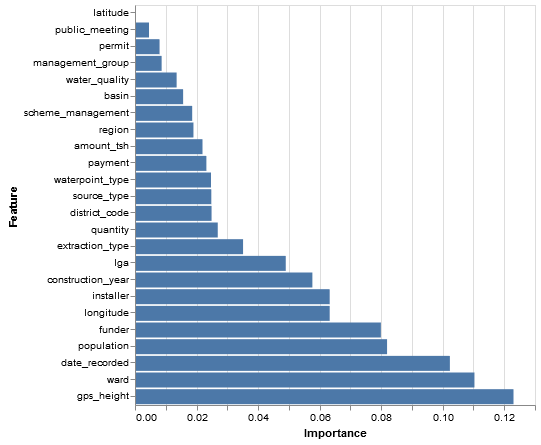

In [138]:
# Create DataFrame of features and importances
importances = pd.DataFrame(
    {"feature": X_train.columns.tolist(), "importance": best.feature_importances_}
)

# Create bar chart object
bars = (
    alt.Chart(importances)
    .mark_bar()
    .encode(
        alt.X("importance:Q", title="Importance"),
        alt.Y(
            "feature:N",
            title="Feature",
            sort=alt.EncodingSortField(field="importance", op="sum", order="ascending"),
        ),
    )
)

# Plot
bars.properties(height=400)

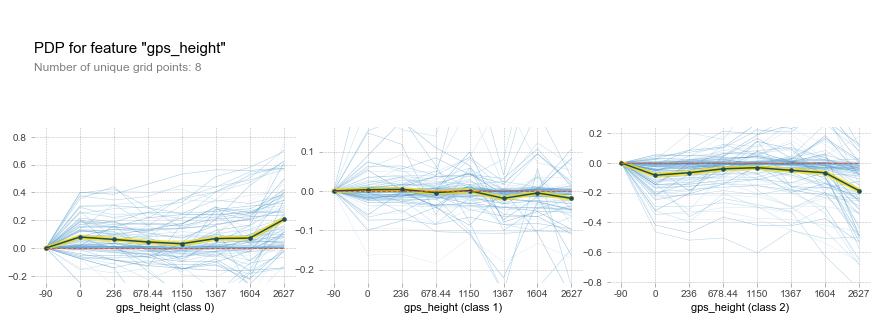

In [155]:
pdp_gps_height = pdp.pdp_isolate(
    model=best, dataset=X_val, model_features=X_val.columns, feature='gps_height'
)

fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_gps_height, feature_name='gps_height', center=True, x_quantile=True, 
    ncols=3, plot_lines=True, frac_to_plot=100
)